<h1 style="text-align: center;">Assignment2 CNN and RNN's</h1>


Libraries and Helper functions 

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

seed = 12345
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# activation functions moduled for resuability
def sigmoid(x):
       return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x,alpha=0.01):
    return x if x>0 else alpha*x

def tanh(x):
    #using np.exp(x)+np.exp(-x) can cause overflow
       return np.tanh(x)

def softmax(x):
       N = np.exp(x-np.max(x))
       return N / np.sum(N, axis=0)

def get_activation_function(name):
    activation_functions = {
        'tanh': tanh,
        'relu': relu,
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid
    }

    AF = activation_functions.get(name.lower())
    if AF:
        return AF
    else:
        raise ValueError(f"Unknown activation function: {AF}")
 

### **Question1** :
 
Convolution function

In [10]:
def convolution_function(image, kernel, stride, P , AF ):

    #get dimesions
    W_in = image.shape[0]
    W_k  = kernel.shape[0]
    H_in = image.shape[1]
    H_k  = kernel.shape[1]
    C = image.shape[2]
    S = stride

    # get activation function
    AF =  get_activation_function(AF)

    # apply padding
    padded_size =  np.array([W_in + 2*P[0], H_in+2*P[1] ,C],dtype=int)
    padded_image = np.zeros(padded_size)

    #copy image onto the padded image
    padded_image[P[0]: P[0]+W_in ,  P[1] : P[1] + H_in , :  ] = image
    output_size = np.array([(W_in-W_k+2*P[0])/S + 1 ,(H_in-H_k+2*P[1])/S + 1 ],dtype=int)
    result = np.zeros(output_size)

    #recompute dimension after padding
    W_in = image.shape[0]
    W_k  = kernel.shape[0]
    H_in = image.shape[1]
    H_k  = kernel.shape[1]
    
    #now calculate the convolution
    for i in range(0,W_in-W_k+1,S):
        for j in range(0,H_in-H_k+1,S):
          conv_sum = np.sum(np.dot(image[i : i + W_k , j : j + H_k , : ].T,kernel))
          result[i // S][j // S] =  AF(conv_sum)
    return result

In [11]:
input_image = Image.open('iith-logo.jpg').convert('RGB')
input_image = input_image.resize((224,224))
input_image = np.array(input_image)

sigmoid
dimensions of original image : (224, 224, 3)
dimensions of kernel :  (5, 5, 3)
dimensions of activation map : (112, 112)


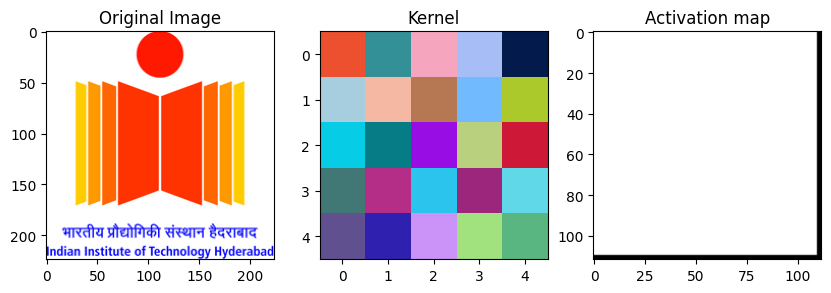

leaky_relu
dimensions of original image : (224, 224, 3)
dimensions of kernel :  (5, 5, 3)
dimensions of activation map : (112, 112)


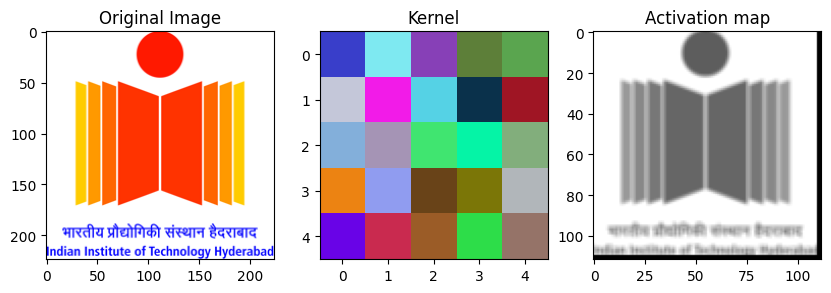

tanh
dimensions of original image : (224, 224, 3)
dimensions of kernel :  (5, 5, 3)
dimensions of activation map : (112, 112)


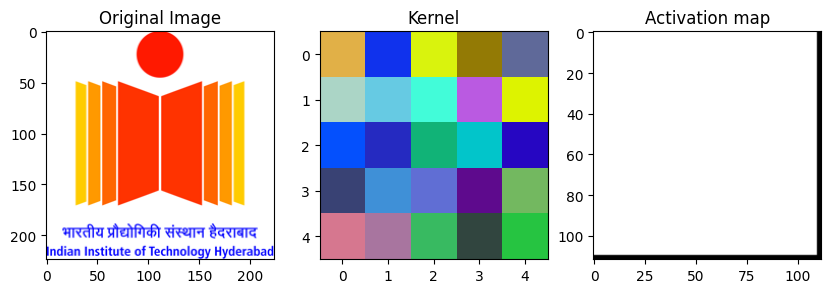

relu
dimensions of original image : (224, 224, 3)
dimensions of kernel :  (5, 5, 3)
dimensions of activation map : (112, 112)


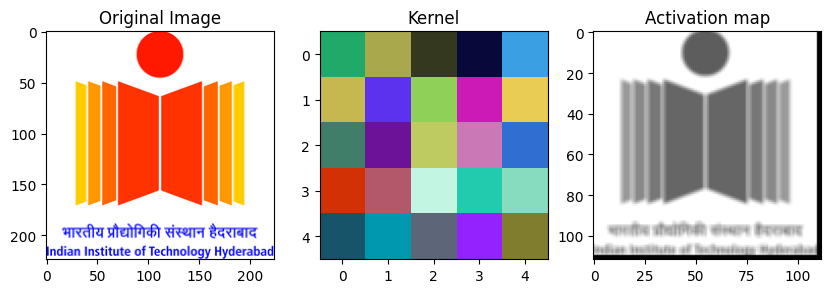

In [12]:
  for AF in ['sigmoid'  , 'leaky_relu' , 'tanh' , 'relu']:
     
    print(AF)
    kernel = np.random.rand(5,5,3)
    activation_map = convolution_function(input_image,kernel,2,(2,2),AF)

    plt.figure(figsize=(10, 5))

    print('dimensions of original image :', input_image.shape)
    print('dimensions of kernel : ',kernel.shape)
    print('dimensions of activation map :', activation_map.shape)

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Original Image')


    # Plot the kernel
    plt.subplot(1, 3, 2)
    plt.imshow(kernel)
    plt.title('Kernel')

    # Plot the Activation map
    plt.subplot(1, 3, 3)
    plt.imshow(activation_map, cmap='gray')
    plt.title('Activation map')

    plt.show()

### **Question 2**:
Pooling function

In [13]:
def pooling_function(pooling_operator, pooling_size ,stride , activation_map_input):
    
    W_in = activation_map_input.shape[0]
    H_in = activation_map_input.shape[1]
    px = pooling_size[0]
    py = pooling_size[1]
    
    pooled_size =  np.array([(W_in-px)/stride + 1 , (H_in-py)/stride + 1 ],dtype=int)
    pooled_output = np.zeros(pooled_size)

    if pooling_operator == 'MAX':
        for i in range(0,W_in-px+1,stride):
            for j in range(0,H_in-py+1,stride):
                     pooled_output[i // stride , j // stride  ] = np.max(activation_map_input[ i : i + px - 1 , j : j + py - 1  ] )

    elif pooling_operator == 'MIN':
        for i in range(0,W_in-px+1,stride):
            for j in range(0,H_in-py+1,stride):
                     pooled_output[i // stride , j // stride  ] = np.min(activation_map_input[ i : i + px - 1 , j : j + py - 1  ] )

    elif pooling_operator == 'AVERAGE':
        for i in range(0,W_in-px+1,stride):
            for j in range(0,H_in-py+1,stride):
                     pooled_output[i // stride , j // stride  ] = np.average(activation_map_input[ i : i + px - 1 , j : j + py - 1  ] ) 
                     
    return pooled_output



dimensions of activation map : (112, 112)
dimensions of pooled output : (56, 56)


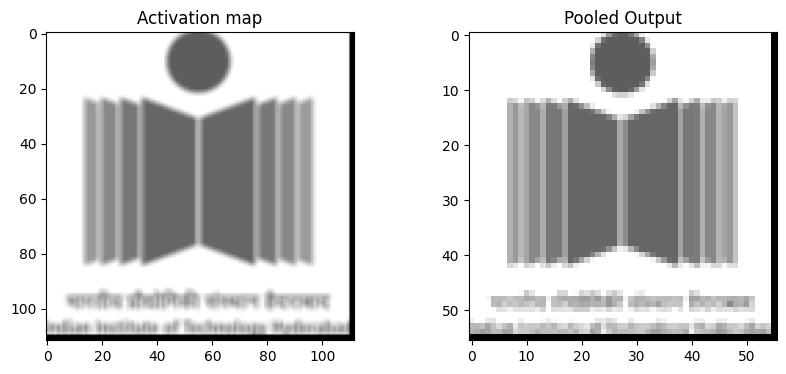

In [14]:
pooled_output = pooling_function('MAX', (2,2), 2 ,activation_map)

print('dimensions of activation map :',activation_map.shape)
print('dimensions of pooled output :',pooled_output.shape)

plt.figure(figsize=(10, 4))

# Plot the kernel
plt.subplot(1, 2, 1)
plt.imshow(activation_map, cmap='gray')
plt.title('Activation map')

# Plot the Activation map
plt.subplot(1, 2, 2)
plt.imshow(pooled_output, cmap='gray')
plt.title('Pooled Output')
plt.show()

### **Question 3:**

 Convolution layer function

In [15]:
def convolution_layer_function(image, Nk, kernel_dim=(5,5,3) , stride=(2) , P=(2,2) , activation_name='relu'):
    
    output_layers = [ ]

    for L in range(Nk):
        kernel = np.random.rand(*kernel_dim)
        convol_layer = convolution_function(image,kernel,stride,P,activation_name)
        output_layers.append(convol_layer)
    
    output = np.stack(output_layers, axis=-1)

    return output

In [16]:
activation_final_volume =  convolution_layer_function(input_image,3,(4,4,3),2,(2,2),'relu')
print('dimension of input image is ',input_image.shape)
print('dimension of padding is ',(2,2))
print('kernel dimesions: ',(4,4,3) )
print('dimension of activation map of image  is ',activation_final_volume.shape)


dimension of input image is  (224, 224, 3)
dimension of padding is  (2, 2)
kernel dimesions:  (4, 4, 3)
dimension of activation map of image  is  (113, 113, 3)


### **Question 4** : 
Pooling layer function 

In [17]:
def pooling_layer_function(input_map_volume ,pooling_size ,pooling_operator , stride):

    pooled_output = [ ]
    for i in range(input_map_volume.shape[2]):
        pooled_layer = pooling_function(pooling_operator, pooling_size, stride, input_map_volume[ :  , : , i])
        pooled_output.append(pooled_layer)
    
    output = np.stack(pooled_output,axis=-1)
    return output 


In [18]:
pooled_output_volume = pooling_layer_function( activation_final_volume ,(2,2) , 'MIN' , 2 )
print('dimension of activation map of image  is ',activation_final_volume.shape)
print('dimension of pooled output volume  is ',pooled_output_volume.shape)


dimension of activation map of image  is  (113, 113, 3)
dimension of pooled output volume  is  (56, 56, 3)


**GAP Layer Demonstration**

In [19]:
#Global AVERAGE pooling layer
#For each channel it takes the whole spatial plane to take the average
#simple put the pooling size the width , height of the image it self

pox = activation_final_volume.shape[0]
poy = activation_final_volume.shape[1]

pooled_output_volume = pooling_layer_function( activation_final_volume ,(pox,poy) , 'AVERGAE' , 2 )
print('dimension of activation map of image  is ',activation_final_volume.shape)
print('dimension of pooled output volume  is ',pooled_output_volume.shape)


dimension of activation map of image  is  (113, 113, 3)
dimension of pooled output volume  is  (1, 1, 3)


### **Question 5**: 
MLP function 

In [20]:
def MLP_function(input_vector , Nh ,hidden_sizes, Non_Linear , output_size):
        
        weights= [ ]   
        biases = [ ] 
        # first weight matrix (input to 1st hidden)
        W = np.random.randn(hidden_sizes[0],input_vector.shape[0]) 
        weights.append(W)
        b = np.random.randn(hidden_sizes[0]) 
        biases.append(b)
        
          # get activation function
        AF =  get_activation_function(Non_Linear)
        
        # middle weights
        if Nh>2:
         for i in range(Nh-1):
            W = np.random.randn(hidden_sizes[i+1],hidden_sizes[i])  
            weights.append(W)  
            b = np.random.randn(hidden_sizes[i+1]) 
            biases.append(b)           

        #output weight matrix
        W = np.random.randn(output_size,hidden_sizes[-1])
        weights.append(W)
        b = np.random.randn(output_size) 
        biases.append(b)

        #Now output
        output = input_vector
        print('printing dimension of i/p and o/p to layers of MLP')
        for i in range(len(weights)):
            temp = output.shape
            output = AF(weights[i] @ output + biases[i])
            print(temp ,'->' , output.shape)


        return output , softmax(output)

In [21]:
MLP_output ,MLP_output_softmax = MLP_function(pooled_output_volume.flatten(),5,[4,5,3,8,9],'relu',4)

printing dimension of i/p and o/p to layers of MLP
(3,) -> (4,)
(4,) -> (5,)
(5,) -> (3,)
(3,) -> (8,)
(8,) -> (9,)
(9,) -> (4,)


### **Question 6** : 
Putting all together

In [22]:
def put_all_together(imput_image):

    # convolution layer with 16Kerenels of 5x5 and RELU
    activation_volume = convolution_layer_function(input_image,16,(5,5,input_image.shape[2]),1,(0,0),'relu')
    print('L1) dimension of output of CNN layer: ',activation_volume.shape)

    # MAX pooling layer with 2x2 and stride 2
    pooled_output_volume = pooling_layer_function( activation_volume ,(2,2) , 'MAX' , 2 )
    print('L2) dimension of output of MAX pool layer: ',pooled_output_volume.shape)

    # CNN layer with 32 kernels of size 3x3 and sigmoid
    activation_volume = convolution_layer_function(pooled_output_volume,32,(3,3,pooled_output_volume.shape[2]),1,(0,0),'sigmoid')
    print('L3) dimension of output of CNN layer: ',activation_volume.shape)

    # MAX pooling layer with 2x2 and stride 2
    pooled_output_volume = pooling_layer_function( activation_volume ,(2,2) , 'MAX' , 2 )
    print('L4) dimension of output of MAX pool layer: ',pooled_output_volume.shape)

    # GAP layer
    pooled_output_volume = pooling_layer_function( pooled_output_volume ,(pooled_output_volume.shape[0],pooled_output_volume.shape[1]) , 'AVERAGE' , 1 )
    print('L4) dimension of output of GAP layer: ',pooled_output_volume.shape)

    #MLP layer
    input_size = pooled_output_volume.flatten().shape[0]
    MLP , MLP_softmax = MLP_function(pooled_output_volume.flatten(),1,[input_size],'relu',1000)
    print('L5) dimension of output of MLP layer: ',MLP_softmax.shape)

    return MLP_softmax

In [23]:
output = put_all_together(input_image)

L1) dimension of output of CNN layer:  (220, 220, 16)
L2) dimension of output of MAX pool layer:  (110, 110, 16)
L3) dimension of output of CNN layer:  (108, 108, 32)
L4) dimension of output of MAX pool layer:  (54, 54, 32)
L4) dimension of output of GAP layer:  (1, 1, 32)
printing dimension of i/p and o/p to layers of MLP
(32,) -> (32,)
(32,) -> (1000,)
L5) dimension of output of MLP layer:  (1000,)


### ***Question 7*** 

Part1 : Dataset creation

In [24]:
def create_dataset(size, sequence_range=(5, 8)):
    X = []
    y = []
    for _ in range(size):
        # randomly generate seq length from range and generate random x_seq values
        seq_length = torch.randint(*sequence_range, size=(1,)).item()
        x_sequence = torch.rand(seq_length, 2)

        # fill two random postions of  x[][2] with 1 
        positions_with_1 = torch.randperm(seq_length)[:2]
        x_sequence[:, 1] = 0
        x_sequence[positions_with_1, 1] = 1

        #Calculate value from the sequnce 
        y_seq = torch.sum(x_sequence[:, 0] * x_sequence[:, 1])
        X.append(x_sequence)
        y.append(y_seq)
        
    y = torch.tensor(y).unsqueeze(1)
    return X, y


Baseline error

In [25]:
#Create a 5000 samples 
X , y = create_dataset(5000,(5,8))

# split the dataset for training and test
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

# shuffle the dataset
indices = np.random.permutation(len(X))
np.random.shuffle(indices)
X_shuffled = [X[i] for i in indices]
Y_shuffled = y[indices]

# Now split the dataset 
X_train, X_test = X_shuffled[:split_index], X_shuffled[split_index:]
Y_train, Y_test = Y_shuffled[:split_index], Y_shuffled[split_index:]


#Calculate the error for model where it always return value 1(baseline error)
baseline_error = 0
for i in range(len(Y_train)):
    baseline_error = baseline_error+(Y_train[i]-1)**2
baseline_error = 0.5 * baseline_error/len(Y_train)

print(baseline_error)

tensor([0.0841])


In [26]:
# Print first 5 samples
print('First Five samples')
print("   x  "+48*' '+" y")
print(58*'-')
for i, (seq_x, seq_y) in enumerate(zip(X[0:5], y[0:5]), start=1):
    s1, s2 = seq_x[:, 0], seq_x[:, 1]
    seq_y_str = '  '.join([f'{val:.2f}' for val in seq_y])
    seq_x1_str = '  '.join([f'{val:.2f}' for val in s1])
    seq_x2_str = '  '.join([f'{val:.2f}' for val in s2])
    x_padding = ' ' * (46 - len(seq_x1_str))  
    print(f"|    {seq_x1_str}{x_padding} | {seq_y_str} |\n|    {seq_x2_str}{x_padding} |      |")
    print(58*'-')

First Five samples
   x                                                   y
----------------------------------------------------------
|    0.88  0.46  0.18  0.57  0.21                   | 1.45 |
|    1.00  0.00  0.00  1.00  0.00                   |      |
----------------------------------------------------------
|    0.72  0.31  0.41  0.09  0.15  0.25             | 0.40 |
|    0.00  0.00  0.00  0.00  1.00  1.00             |      |
----------------------------------------------------------
|    0.28  0.95  0.26  0.47  0.67  0.71  0.35       | 1.14 |
|    0.00  0.00  0.00  1.00  1.00  0.00  0.00       |      |
----------------------------------------------------------
|    0.72  0.77  0.11  0.51  0.81  0.40  0.26       | 0.66 |
|    0.00  0.00  0.00  0.00  0.00  1.00  1.00       |      |
----------------------------------------------------------
|    0.14  0.44  0.50  0.06  0.41  0.57             | 0.64 |
|    1.00  0.00  1.00  0.00  0.00  0.00             |      |
-------------------

Part 2 : Training ELMON Network

We are training traditional RNN network where the network is based on time sequence of the input , Each RNN cell takes inputs $h_{t-1}$ and $x_t$ ,Whereas

   *  $x_t$ is the input at time $t$
   *  $h_{t-1}$ is the hidden state from the previous RNN cell, which handled the input at time $t-1$
   * $h_t$ is hidden state concluded by present RNN cell
   *  $y_{t}$ is the ouput from the RNN cell



Forward pass equations:
\begin{align}
     h_{t} & = tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_{h}) \\
     y_{t} & = W_{hy}h_t + b_y
 \end{align}
   

In [27]:
import torch.nn as nn

class ELMON(nn.Module):
    def __init__(self, x_size, h_size, o_size):
        super().__init__()

        #Also store sizes for future use
        self.x_size = x_size
        self.h_size = h_size
        self.o_size = o_size

        # RNN cell operations weights and biases
        self.W_xh = nn.Parameter(torch.randn(h_size, x_size))
        self.W_hh = nn.Parameter(torch.randn(h_size, h_size))
        self.b_h = nn.Parameter(torch.randn(h_size))

        # RNN output weights and biases
        self.W_hy = nn.Parameter(torch.randn(o_size, h_size))
        self.b_y = nn.Parameter(torch.randn(o_size))

    # forward pass for each RNN cell
    def forward_t(self, x_t, h_t, t):
        hidden = torch.matmul(self.W_xh,x_t) + self.b_h + torch.matmul(self.W_hh,h_t) 
        hidden1 = torch.tanh(hidden)
        output = torch.matmul(self.W_hy,hidden1) + self.b_y
        return output, hidden1

    def forward(self,x):
          h_t = torch.zeros(self.h_size)
          for t in range(len(x)):
                    x_t = x[t]
                    y_pred , h_t = self.forward_t(x_t, h_t ,t)
          return y_pred 


    # MSE loss function
    def loss_function(self , y_pred , y_correct):
        return 0.5*(y_pred - y_correct)**2
    
    def predict(self , X):
       with torch.no_grad():
        predictions = []
        for i in range(len(X)):
            y_pred = self.forward(X[i])
            predictions.append(y_pred)
        return predictions

    # training algorithim (SGD backprop)
    def train_model(self , X , y , learning_rate=0.001 ,max_epochs=100):
        # each input is a sequence
        # lets use SGD
          train_error_info = [ ]
          for epoch in range(max_epochs):
              Net_loss = 0
              # for each sequence
              for i in range(len(X)):
                  
                 # start prediction for each element of the sequence
                 y_pred = self.forward(X[i])
                 #end of prediction

                
                 #clear out gradient values and do back prop
                 loss = self.loss_function(y_pred , y[i])
                 Net_loss = Net_loss + loss.item()
              
                 self.zero_grad()
                 loss.backward()
              
                 with torch.no_grad():
                        for param in self.parameters():
                            param -= learning_rate * param.grad.data
              print('Average loss at epoch ',epoch+1,'is :',Net_loss/len(X))
              train_error_info.append([epoch+1,Net_loss/len(X)])          
       
          predictions = []
          for i in range(len(X)):
            y_pred = self.forward(X[i])
            predictions.append(y_pred)
          return predictions  , train_error_info          

                    

In [28]:
input_size = 2
hidden_size = 8
output_size = 1
model1 = ELMON(input_size, hidden_size, output_size)

# Train the model
predictions , train_error_info0 = model1.train_model(X_train, Y_train, 0.004, 30)


Average loss at epoch  1 is : 0.11677421056879805
Average loss at epoch  2 is : 0.08574897869756219
Average loss at epoch  3 is : 0.08436549513543795
Average loss at epoch  4 is : 0.08359080747128632
Average loss at epoch  5 is : 0.08323883901935954
Average loss at epoch  6 is : 0.08276102059106875
Average loss at epoch  7 is : 0.08235831214485774
Average loss at epoch  8 is : 0.08191640236025065
Average loss at epoch  9 is : 0.08158783267261671
Average loss at epoch  10 is : 0.08131941126666196
Average loss at epoch  11 is : 0.08105491894348996
Average loss at epoch  12 is : 0.08078806777729695
Average loss at epoch  13 is : 0.08053491284409446
Average loss at epoch  14 is : 0.080332343527676
Average loss at epoch  15 is : 0.0800609561494591
Average loss at epoch  16 is : 0.07970955057763829
Average loss at epoch  17 is : 0.0796842864482477
Average loss at epoch  18 is : 0.0793145482894669
Average loss at epoch  19 is : 0.07872178900406285
Average loss at epoch  20 is : 0.078438696695

In [29]:
test_predictions0 = model1.predict(X_test)
Net_test_loss0 = 0
for i in range(len(X_test)):
    Net_test_loss0+= 0.5*(test_predictions0[i]-Y_test[i])**2
print('MSE Test Loss equals to ', Net_test_loss0/len(X_test))

MSE Test Loss equals to  tensor([0.0372])


Part 3: Training LSTM network
We are training a LSTM network which handles long-term dependencies well

Foward Pass equations:
1) forget function (f_t)
\begin{align}
 f_t = \sigma(W_f [h_{t-1} , x_t ] + b_f)
\end{align}

2) input gate function(i_t) and candidate cell state function (&tilde;c_t)
 \begin{align}
  i_t &= \sigma(W_i [h_{t-1} , x_t ] + b_i) \\
  \stackrel{\sim}{c_t} &=  tanh(W_c [h_{t-1} , x_t ] + b_c)
 \end{align}

3) cell state earse and write operations
\begin{align}
  c_{t} = f_{t}*c_{t-1} + i_t*\stackrel{\sim}{c_t}
\end{align} 

4) output gate operations
\begin{align}
  o_t & = \sigma(W_o [h_{t-1} , x_t ] + b_o) \\
  h_{t} & = o_t*tanh(c_t)
\end{align}

5) output of cell
\begin{align}
 y_t = W_{hy}h_t + b_y
\end{align}

In [30]:
class LSTM(nn.Module):
    def __init__(self, x_size, h_size, o_size):
        super().__init__()

        #Also store sizes for future use
        self.x_size = x_size
        self.h_size = h_size
        self.o_size = o_size

        # RNN cell operations weights
        self.W_f = nn.Parameter(torch.randn(h_size , h_size + x_size))
        self.W_i = nn.Parameter(torch.randn(h_size , h_size + x_size ))
        self.W_c = nn.Parameter(torch.randn( h_size , h_size + x_size ))
        self.W_o = nn.Parameter(torch.randn(h_size, h_size + x_size ))
        
        self.b_f = nn.Parameter(torch.randn(h_size))
        self.b_i = nn.Parameter(torch.randn(h_size))
        self.b_c = nn.Parameter(torch.randn(h_size))
        self.b_o = nn.Parameter(torch.randn(h_size))

        # RNN output weights
        self.W_hy = nn.Parameter(torch.randn(o_size, h_size))
        self.b_y = nn.Parameter(torch.randn(o_size))

    # forward pass for each RNN cell
    def forward_t(self, x_t, h_t , c_t , t):
        
        # forget gate
        combined = torch.cat((h_t, x_t))
       
        f_t = torch.sigmoid(torch.matmul(self.W_f,combined)+self.b_f)

        #input gate
        i_t = torch.sigmoid(torch.matmul(self.W_i,combined)+self.b_i)
        can_t = torch.tanh(torch.matmul(self.W_c,combined)+self.b_c)

        #now do the operations
        c_t1 = f_t*c_t + i_t*can_t

        #output gate
        o_t = torch.sigmoid(torch.matmul(self.W_o,combined)+self.b_o)
        h_t1 = o_t*torch.tanh(c_t1) 

        #convert to y
        y_pred =  torch.matmul(self.W_hy , h_t1 ) + self.b_y

        return y_pred , h_t1 , c_t1


    def predict(self , X):
        predictions = []
        for i in range(len(X)):
            y_pred = self.forward(X[i])
            predictions.append(y_pred)
        return predictions

    def forward(self,x):
          h_t = torch.zeros(self.h_size)
          c_t = torch.zeros(self.h_size)
          for t in range(len(x)):
                    x_t = x[t]
                    y_pred , h_t , ct= self.forward_t(x_t, h_t , c_t , t)
          return y_pred 


    # MSE loss function
    def loss_function(self , y_pred , y_correct):
        return 0.5*(y_pred - y_correct)**2

    def predict(self , X):
      with torch.no_grad():
        predictions = []
        for i in range(len(X)):
            y_pred = self.forward(X[i])
            predictions.append(y_pred)
        return predictions

    # training algorithim (SGD backprop)
    def train_model(self , X , y , learning_rate=0.001 ,max_epochs=100):
        # each input is a sequence is seq_length
        # lets use SGD
          train_error_info = [ ]
          for epoch in range(max_epochs):
              Net_loss = 0
              # for dataset
              for i in range(len(X)):
                  
                 # start prediction for each element of the sequence
                 y_pred = self.forward(X[i])
                 #end of prediction

                
                 #clear out gradient values and do back prop
                 loss = self.loss_function(y_pred , y[i])
                 Net_loss = Net_loss + loss.item()
              
                 self.zero_grad()
                 loss.backward()
              
                 with torch.no_grad():
                        for param in self.parameters():
                            param -= learning_rate * param.grad.data
              print('Average loss at epoch ',epoch+1,'is :',Net_loss/len(X))
              train_error_info.append([epoch+1,Net_loss/len(X)])          
        
       
          predictions = []
          for i in range(len(X)):
            y_pred = self.forward(X[i])
            predictions.append(y_pred)
          return predictions  , train_error_info           

                    

In [31]:
input_size = 2
hidden_size = 8
output_size = 1
model2 = LSTM(input_size, hidden_size, output_size)

# Train the model
predictions , train_error_info1 = model2.train_model(X_train, Y_train, 0.004, 30)


Average loss at epoch  1 is : 0.12238020959624546
Average loss at epoch  2 is : 0.0701918727664928
Average loss at epoch  3 is : 0.06177619773175943
Average loss at epoch  4 is : 0.05199170091157868
Average loss at epoch  5 is : 0.035497172355616294
Average loss at epoch  6 is : 0.018607376297178527
Average loss at epoch  7 is : 0.012871906846550625
Average loss at epoch  8 is : 0.010371281372577538
Average loss at epoch  9 is : 0.008815309654472038
Average loss at epoch  10 is : 0.00774598378505858
Average loss at epoch  11 is : 0.006959428811709254
Average loss at epoch  12 is : 0.006349011130225995
Average loss at epoch  13 is : 0.0058554955548852095
Average loss at epoch  14 is : 0.005444127390397489
Average loss at epoch  15 is : 0.005093339944525866
Average loss at epoch  16 is : 0.004789003126137747
Average loss at epoch  17 is : 0.004521425063587547
Average loss at epoch  18 is : 0.004283671819079599
Average loss at epoch  19 is : 0.004070622667766212
Average loss at epoch  20 

Testing Error

In [32]:
test_predictions1 = model2.predict(X_test)
Net_test_loss1 = 0
for i in range(len(X_test)):
    Net_test_loss1+= 0.5*(test_predictions1[i]-Y_test[i])**2
print('MSE Test Loss equals to ', Net_test_loss1/len(X_test))

MSE Test Loss equals to  tensor([0.0021])


Part 4: Training GRU network which is variant of LSTM in which cell state is removed
Forward pass equations:

1) reset gate operations:
   \begin{align}
      r_t = \sigma(W_r [h_{t-1} , x_t ])
   \end{align}

2) update gate operations( z_t and candidate hidden state):
   \begin{align}
      z_t & = \sigma(W_z [h_{t-1} , x_t ]) \\
      \stackrel{\sim}{h_{t}}& = tanh(W [r_t * h_{t-1} , x_t ])
   \end{align}

3) hidden state update
   \begin{align}
     h_{t} = (1-z_t)*h_{t-1} + z_t*\stackrel{\sim}{h_{t}}
   \end{align}

4) output of cell
\begin{align}
 y_t = W_{hy}h_t + b_y
\end{align}




In [33]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, x_size, h_size, o_size):
        super().__init__()

        #Also store sizes for future use
        self.x_size = x_size
        self.h_size = h_size
        self.o_size = o_size

        # RNN cell operations weights
        self.W_z = nn.Parameter(torch.randn(h_size , h_size + x_size))
        self.W_r = nn.Parameter(torch.randn( h_size , h_size + x_size ))
        self.W = nn.Parameter(torch.randn(h_size , h_size + x_size ))
        

        # RNN output weights
        self.W_hy = nn.Parameter(torch.randn(o_size, h_size))
        self.b_y = nn.Parameter(torch.randn(o_size))

    # forward pass for each RNN cell
    def forward_t(self, x_t, h_t , t):
        
        combined = torch.cat((h_t, x_t))
       
        #reset gate
        r_t = torch.sigmoid(torch.matmul(self.W_r , combined) )

        #update gate
        z_t = torch.sigmoid(torch.matmul(self.W_z  , combined ) )

        combined2 = torch.cat((r_t*h_t, x_t))
        h_cant = torch.tanh(torch.matmul(self.W ,combined2))

        h_t1 = (1-z_t)*h_t + z_t*h_cant

        #convert to y
        y_pred =  torch.matmul(self.W_hy, h_t1) + self.b_y

        return y_pred , h_t1 


    def forward(self,x):
          h_t = torch.zeros(self.h_size)
          c_t = torch.zeros(self.h_size)
          for t in range(len(x)):
                    x_t = x[t]
                    y_pred , h_t = self.forward_t(x_t, h_t  , t)
          return y_pred 


    # MSE loss function
    def loss_function(self , y_pred , y_correct):
        return 0.5*(y_pred - y_correct)**2

    def predict(self , X):
       with torch.no_grad():
        predictions = []
        for i in range(len(X)):
            y_pred = self.forward(X[i])
            predictions.append(y_pred)
        return predictions


     # training algorithim (SGD backprop)
    def train_model(self , X , y , learning_rate=0.001 ,max_epochs=100):
        # each input is a sequence is seq_length
        # lets use SGD
          train_error_info = [ ]
          for epoch in range(max_epochs):
              Net_loss = 0
              # for each sequence
              for i in range(len(X)):
                  
                 # start prediction for each element of the sequence
                 y_pred = self.forward(X[i])
                 #end of prediction

                
                 #clear out gradient values and do back prop
                 loss = self.loss_function(y_pred , y[i])
                 Net_loss = Net_loss + loss.item()
              
                 self.zero_grad()
                 loss.backward()
              
                 with torch.no_grad():
                        for param in self.parameters():
                            param -= learning_rate * param.grad.data
              print('Average loss at epoch ',epoch+1,'is :',Net_loss/len(X))
              train_error_info.append([epoch+1,Net_loss/len(X)])        
       
          predictions = []
          for i in range(len(X)):
            y_pred = self.forward(X[i])
            predictions.append(y_pred)
          return predictions  , train_error_info          

                    

In [34]:
input_size = 2
hidden_size = 8
output_size = 1
model3 = GRU(input_size, hidden_size, output_size)

# Train the model
predictions , train_error_info2 = model3.train_model(X_train, Y_train, 0.004, 30)


Average loss at epoch  1 is : 0.09616235048876468
Average loss at epoch  2 is : 0.04824688927191238
Average loss at epoch  3 is : 0.033200722122825634
Average loss at epoch  4 is : 0.024075367180904732
Average loss at epoch  5 is : 0.018484213782407038
Average loss at epoch  6 is : 0.014873183164795743
Average loss at epoch  7 is : 0.012369787259538014
Average loss at epoch  8 is : 0.0105449403376935
Average loss at epoch  9 is : 0.009161301731600015
Average loss at epoch  10 is : 0.008078730468533043
Average loss at epoch  11 is : 0.007213425298453585
Average loss at epoch  12 is : 0.006511549315760851
Average loss at epoch  13 is : 0.005934489579632004
Average loss at epoch  14 is : 0.005452599428310416
Average loss at epoch  15 is : 0.005042882392172552
Average loss at epoch  16 is : 0.004687889885705498
Average loss at epoch  17 is : 0.00437476145481192
Average loss at epoch  18 is : 0.0040942287613400285
Average loss at epoch  19 is : 0.003839675852591738
Average loss at epoch  20

Testing Error

In [35]:
test_predictions2 = model3.predict(X_test)
Net_test_loss2 = 0
for i in range(len(X_test)):
    Net_test_loss2+= 0.5*(test_predictions2[i]-Y_test[i])**2
print('MSE Test Loss equals to ', Net_test_loss2/len(X_test))

MSE Test Loss equals to  tensor([0.0018])


Part 5: Comparsion

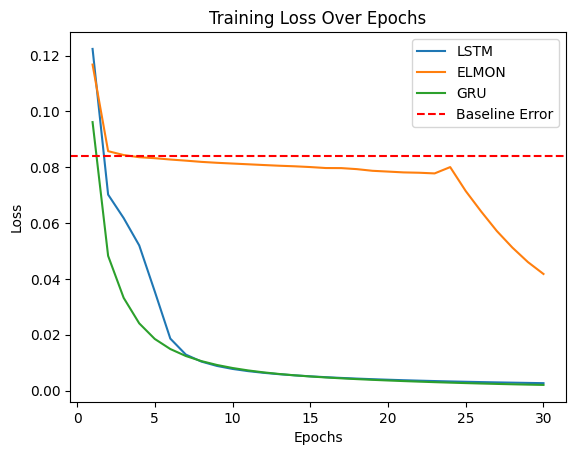

In [36]:
epochs1, losses1 = zip(*train_error_info1)
epochs0, losses0 = zip(*train_error_info0)
epochs2, losses2 = zip(*train_error_info2)

# Plotting
plt.plot(epochs1, losses1, label='LSTM')
plt.plot(epochs0, losses0, label='ELMON')
plt.plot(epochs2, losses2, label='GRU')
plt.axhline(y=baseline_error, color='r', linestyle='--', label='Baseline Error')

# Legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Observations:
* Traditional RNN is not able to capture the long term dependecies due to vanishing gradient problem
* LSTM is good model but resource expensive
* GRU has less computation(faster) and resource consumption
* Both LSTM and GRU exhibit similar results  